960 False
data_path: /data/disk1/liuchengjun/HNNS/sample/wikipedia.base.M_32.efc_1000.efs_1000.ck_ts_1000.ncheck_100.recall@1000
4192 213462
avg recall: 951.150172
[Checkpoint] /data/disk1/liuchengjun/HNNS/checkpoint/wikipedia.base.M_32.efc_1000.efs_1000.ck_ts_1000.ncheck_100.recall@1000.thr_960.classification.cross_0.txt exist!
[Checkpoint] Loaded!
importance_classification       query: 83.16, update: 147.33333333333334, degree: 31.30,          dist: 40.92, cross: 0
update importance_classification       update0: 87.00, update1: 231.00, update2: 124.00
Area Under the Curve (AUC): 0.7488


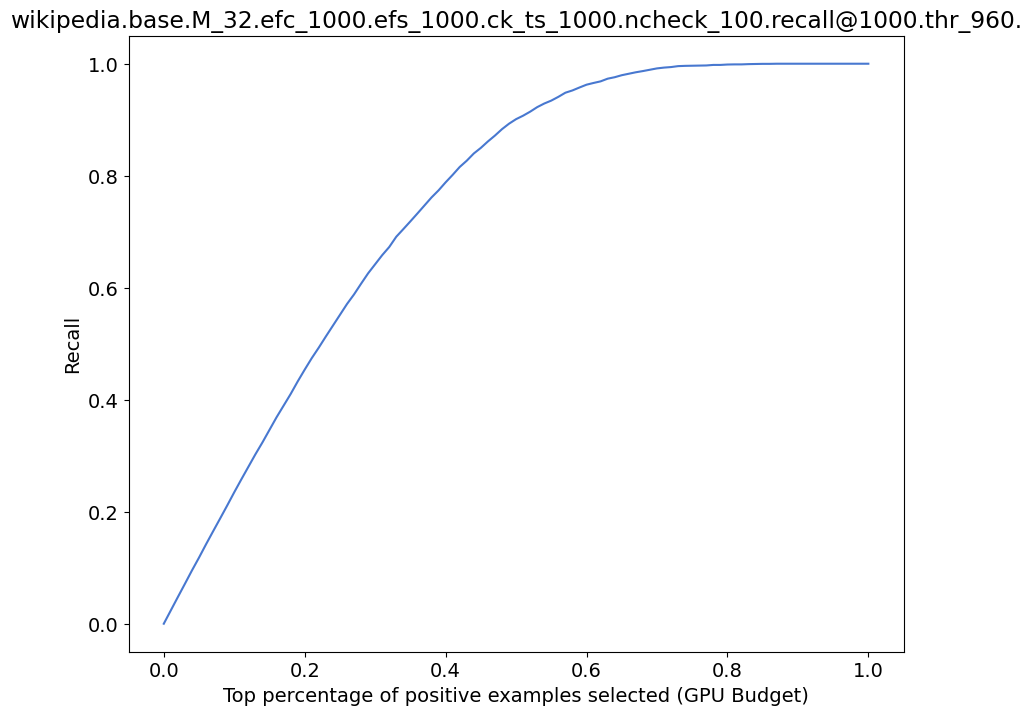

train_number_recall_mn: 0


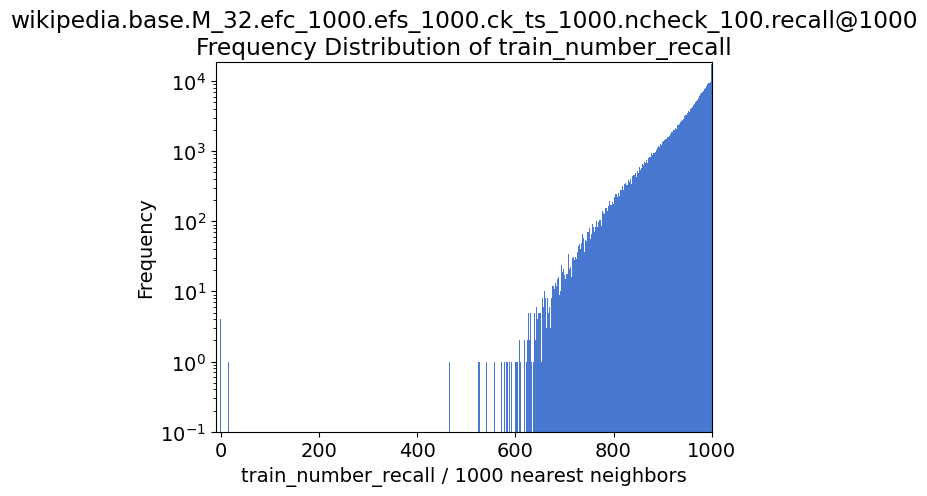

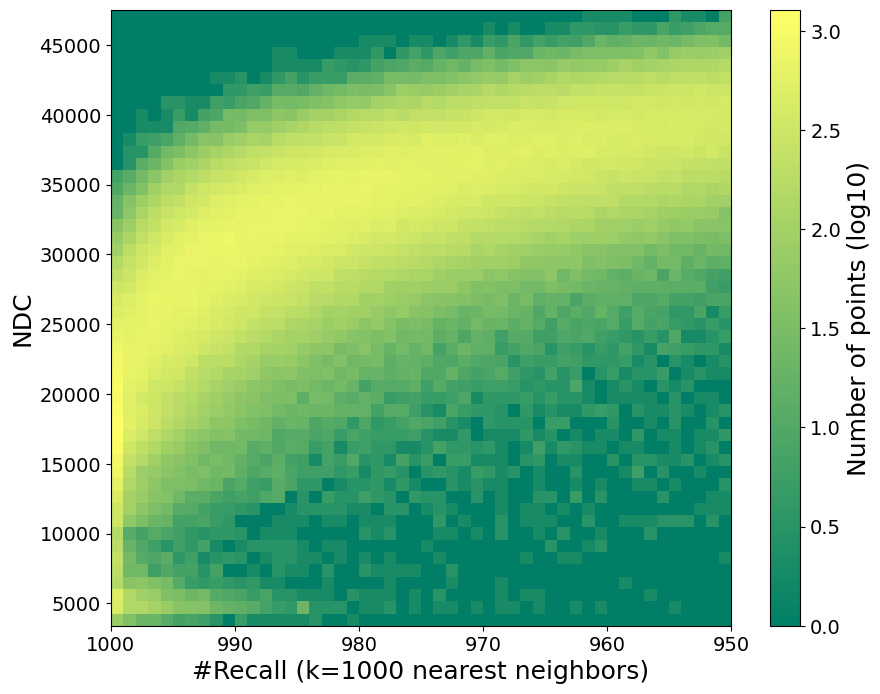

pearsonr: -0.7430 | p: 0.0000
roc_auc_score: 0.9283
recall: 0.8073 | precision: 0.8176
avg scores: 996.54


In [37]:
# conda activate /home/zhengweiguo/miniconda3/envs/hnns
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from binary_io import *
import json
import os

IID = False

dataset = 'gist1m'
dataset = 'DEEP100m.base'
dataset = 'ImageNet.base'
dataset = 'SPACEV100m.base'
dataset = 'Datacomp-text.base'
dataset = 'Datacomp-image.base'
dataset = 'Wikipedia.base'
config = json.loads(open('config.json').read())
efs = config[dataset]["efs"]

query_only=False
if IID:
    M = 32
else:
    threshold = config[dataset]["best_thr"]
    M = config[dataset]["M"]
# threshold = 650


print(threshold, query_only)
dim = config[dataset]["dim"]
efc = 1000
ck_ts = 1000
k = 1000
topk = 0

data_prefix = '/data/disk1/liuchengjun/HNNS/sample/'
checkpoint_prefix = '/data/disk1/liuchengjun/HNNS/checkpoint/'
prefix = f'{dataset.lower()}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}'
if IID:
    prefix += '.IID'
checkpoint_classification_path = f'{checkpoint_prefix}{prefix}.thr_{threshold}.classification.cross_{topk}.{"qonly." if query_only else ""}txt'
checkpoint_regression_path = f'{checkpoint_prefix}{prefix}.thr_{threshold}.regression.cross_{topk}.{"qonly." if query_only else ""}txt'

train_feature = fvecs_read(f'{data_prefix}{prefix}.train_feats_nn.fvecs')
test_feature = fvecs_read(f'{data_prefix}{prefix}.test_feats_nn.fvecs')[:, :]
if query_only:
    train_feature = train_feature[:, :dim]
    test_feature = test_feature[:, :dim]

print(f'data_path: {data_prefix}{prefix}')
train_number_recall = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 0]
train_comps = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 1]
test_number_recall = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 0]
test_comps = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 1]

train_label_classification = train_number_recall < threshold
test_label_classification = test_number_recall < threshold
# train_label_classification = 1.000 - train_number_recall / 1000
# test_label_classification = 1.000 - test_number_recall / 1000
train_label_regression = np.log2(train_comps + 1)
test_label_regression = np.log2(test_comps + 1)

print(np.sum(test_label_classification), np.sum(train_label_classification))
print(f'avg recall: {np.mean(train_number_recall)}')

# # 计算方差最大的top10个特征
# variances = np.var(train_feature, axis=0)
# top_indices = np.argsort(variances)[-topk:]
# print(top_indices)
# 把这top10个特征进行交叉组合
for i in range(topk):
    for j in range(i+1, topk):
        cross_train = np.multiply(train_feature[:, i], train_feature[:, j]).reshape(-1, 1)
        train_feature = np.concatenate((train_feature, cross_train), axis=1)
        cross_test = np.multiply(test_feature[:, i], test_feature[:, j]).reshape(-1, 1)
        test_feature = np.concatenate((test_feature, cross_test), axis=1)
        

df = pd.DataFrame()

offset = 0
feat_query = train_feature[:, offset: offset + dim]
query_cols = [f"query_{i}" for i in range(dim)]
df_query = pd.DataFrame(feat_query, columns=query_cols)
df = pd.concat([df, df_query], axis = 1)
offset += dim

feat_query = train_feature[:, offset: offset + topk * (topk - 1) // 2]
query_cols = [f"cross_{i}" for i in range(topk * (topk - 1) // 2)]
df_query = pd.DataFrame(feat_query, columns=query_cols)
df = pd.concat([df, df_query], axis = 1)
offset += topk * (topk - 1) // 2

if offset < len(train_feature[0]):
    feat_dist = train_feature[:, offset: offset + 100]
    dist_cols = [f"dist_{i}" for i in range(100)]
    df_dist = pd.DataFrame(feat_dist, columns=dist_cols)
    df = pd.concat([df, df_dist], axis = 1)
    offset += 100
if offset < len(train_feature[0]):
    feat_dist = train_feature[:, offset: offset + 10]
    degree_cols = [f"degree_{i}" for i in range(10)]
    df_degree = pd.DataFrame(feat_dist, columns=degree_cols)
    df = pd.concat([df, df_degree], axis = 1)
    offset += 10
if offset < len(train_feature[0]):
    feat_update = train_feature[:, offset: offset + 3]
    update_cols = [f"update_{i}" for i in range(3)]
    df_update = pd.DataFrame(feat_update, columns=update_cols)
    df = pd.concat([df, df_update], axis = 1)
    offset += 3

assert offset == len(train_feature[0])
        
##################################################  ##################################################

params_classification = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_boost_round': 3000,
    'verbose': 1,
    "num_threads": 96
}

params_regression = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.05,
    'num_boost_round': 3000,
    'verbose': 1,
    "num_threads": 96
}

##################################################  ##################################################

if os.path.exists(checkpoint_classification_path):
    print(f'[Checkpoint] {checkpoint_classification_path} exist!')
    gbm_classification = lgb.Booster(model_file = checkpoint_classification_path)
    print('[Checkpoint] Loaded!')
else:
    print(f'[Checkpoint] {checkpoint_classification_path} not exist!')
    print('[Checkpoint] Training!')
    gbm_classification = lgb.train(params_classification, lgb.Dataset(df.values, label=train_label_classification))
    gbm_classification.save_model(checkpoint_classification_path)
    print('[Checkpoint] Done!')
    
# if os.path.exists(checkpoint_regression_path):
#     print(f'[Checkpoint] {checkpoint_regression_path} exist!')
#     gbm_regression = lgb.Booster(model_file = checkpoint_regression_path)
#     print('[Checkpoint] Loaded!')
# else:
#     print(f'[Checkpoint] {checkpoint_regression_path} not exist!')
#     print('[Checkpoint] Training!')
#     gbm_regression = lgb.train(params_regression, lgb.Dataset(df.values, label=train_label_regression))
#     gbm_regression.save_model(checkpoint_regression_path)
#     print('[Checkpoint] Done!')

train_pred_classification = gbm_classification.predict(train_feature)
sorted_train_pred_classification = np.sort(train_pred_classification)

importance_classification = gbm_classification.feature_importance()
feature_names = df.columns
query_imp, update_imp, dist_imp, degree_imp, cross_imp = 0, 0, 0, 0, 0
update_imp_0, update_imp_1, update_imp_2 = 0, 0, 0
for f, imp in zip(feature_names, importance_classification):
    if f.startswith('query'):
        query_imp += imp
    elif f.startswith('update'):
        if f.endswith('0'):
            update_imp_0 += imp
        elif f.endswith('1'):
            update_imp_1 += imp
        elif f.endswith('2'):
            update_imp_2 += imp
        update_imp += imp
    elif f.startswith('dist'):
        dist_imp += imp
    elif f.startswith('degree'):
        degree_imp += imp
    elif f.startswith('cross'):
        cross_imp += imp
    # print(f, imp)
print(f'importance_classification \
      query: {query_imp / dim:.2f}, update: {update_imp / 3}, degree: {degree_imp / 10:.2f},    \
      dist: {dist_imp / 100:.2f}, cross: {0 if topk==0 else cross_imp / (topk * (topk - 1) / 2)}')
print(f'update importance_classification \
      update0: {update_imp_0:.2f}, update1: {update_imp_1:.2f}, update2: {update_imp_2:.2f}')
##################################################  ##################################################

from sklearn.metrics import recall_score
import time
import numpy as np
from sklearn.metrics import recall_score, roc_auc_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import trapezoid as trapz
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


start = time.time()
label_pred_classification = gbm_classification.predict(test_feature)
# label_pred_regression = gbm_regression.predict(test_feature)
# label_pred_combined = (label_pred_classification) * (label_pred_regression)
label_pred_combined = label_pred_classification
# label_pred_combined = label_pred_regression
end = time.time()

def recall_curve(test_label_classification, label_pred_combined):
    n = len(label_pred_combined)
    recalls = []
    percentages = np.arange(0, 1.01, 0.01)  # 从0%到100%，步长为1%
    for p in percentages:
        threshold = np.percentile(label_pred_combined, 100 * (1 - p))
        if p==0: threshold += 1
        new_label_pred = np.where(label_pred_combined >= threshold, 1, 0)
        recall = recall_score(test_label_classification, new_label_pred)
        recalls.append(recall)
    return percentages, recalls

percentages, recalls = recall_curve(test_label_classification, label_pred_combined)
auc = trapz(recalls, percentages)
print(f"Area Under the Curve (AUC): {auc:.4f}")

total_true_label = np.sum(test_label_classification)

plt.figure(figsize=(10, 8))
plt.plot(percentages, recalls)
plt.xlabel("Top percentage of positive examples selected (GPU Budget)")
plt.ylabel("Recall")
fig_path = f'{prefix}.thr_{threshold}.{"q_only." if query_only else ""}'
plt.title(fig_path)
plt.savefig(fig_path + 'png', dpi=300)
plt.show()

train_number_recall_mn = np.min(train_number_recall)
hist, bins = np.histogram(train_number_recall, bins = range(0, 1000 + 1))
plt.bar(bins[: -1], hist, width = 1)
plt.xlabel('train_number_recall / 1000 nearest neighbors')
plt.xlim([train_number_recall_mn - 10, 1000])
plt.ylim(0.1)
plt.yscale('log')
plt.ylabel('Frequency')
plt.title(f'{prefix}\nFrequency Distribution of train_number_recall')
print(f'train_number_recall_mn: {train_number_recall_mn}')
fig_path = f'{prefix}.recall_hist'
plt.savefig(fig_path + '.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 14
train_comps_filtered = train_comps[train_number_recall >= 950]
train_number_recall_filtered = train_number_recall[train_number_recall >= 950]
origin_heatmap, xedges, yedges = np.histogram2d(train_number_recall_filtered, train_comps_filtered, bins=50)
heatmap = np.log10(origin_heatmap + 1)

colors = [(215/255, 46/255, 37/255),
          (244/255, 109/255, 67/255),
          (254/255, 224/255, 139/255),
          (255/255, 255/255, 255/255),
          (166/255, 217/255, 106/255),
          (26/255, 152/255, 80/255)]
colors = colors[::-1]
# cmap = ListedColormap(colors)
cmap = sns.color_palette("YlGnBu", as_cmap=True)

my_cmap = LinearSegmentedColormap.from_list('my_cmap', ['azure', 'lightseagreen'])
hm = plt.imshow(heatmap.T, origin = 'lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect = 'auto',
                # cmap='Wistia'
                cmap='summer'
                # cmap=my_cmap
                # cmap='pastel'
)

# font size=18
plt.xlabel(f'#Recall (k=1000 nearest neighbors)', fontsize=18)
# plt.xlabel(f'#Recall / 1000 nearest neighbors\n{len(train_number_recall)} points')
plt.ylabel('NDC', fontsize=18)
# plt.xlim([990, 1000])
ax = plt.gca()
ax.invert_xaxis()
cbar = plt.colorbar(hm)
cbar.set_label('Number of points (log10)', fontsize=18)

fig_path = f'{prefix}.Comp_R'
plt.savefig(fig_path + '.png', dpi=500)
plt.savefig(fig_path + '.pdf', dpi=500, bbox_inches='tight')
plt.show()
# for R in range(950, 1001):
#     print(f'avg comparison for {R/1000}: {np.mean(train_comps[train_number_recall == R]):.2f}')

# pearson coef r
r, p = pearsonr(train_number_recall, train_comps)
print(f'pearsonr: {r:.4f} | p: {p:.4f}')

# roc_auc score
from sklearn.metrics import roc_auc_score
roc_auc_score = roc_auc_score(test_label_classification, label_pred_combined)
print(f'roc_auc_score: {roc_auc_score:.4f}')

# recall, precision and F1 score
from sklearn.metrics import recall_score, precision_score
recall = recall_score(test_label_classification, label_pred_combined > 0.5)
precision = precision_score(test_label_classification, label_pred_combined > 0.5)
print(f'recall: {recall:.4f} | precision: {precision:.4f}')

##################################################  ##################################################

pct50 = np.percentile(label_pred_combined, 50)
label_pred_sorted = np.sort(label_pred_combined)
step = 0.5
scores = []
for p in np.arange(0, 100 + step, step):
    pct_thr = label_pred_sorted[min(int(len(label_pred_sorted) * p / 100), len(label_pred_sorted) - 1)]
    cpu_idx = label_pred_combined < pct_thr
    gpu_idx = label_pred_combined >= pct_thr
    cpu_recall_cnt = test_number_recall[cpu_idx]
    overall_recall = (np.sum(cpu_recall_cnt) + 1000 * np.sum(gpu_idx)) / len(test_label_classification)
    # print(f'{p}%->{pct_thr:.2f} | cpu workload: {np.sum(cpu_idx)} | \
    #     gpu workload: {np.sum(gpu_idx)} | \
    #     overall recall: {overall_recall:6f}')
    if overall_recall > 990:
        scores.append(overall_recall)

scores = np.array(scores)
print(f'avg scores: {np.mean(scores):.2f}')


In [16]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
